<a href="https://colab.research.google.com/github/ShachiniMekala/Google_PlayStore_Analysis/blob/Mekala/Copy_of_pySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background Work

In [ ]:
!pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.6.2-cp37-none-any.whl size=10735 sha256=69de18579bdf0f47951e1154b28caa984cbfd806eae1d16c1b21f6fc7265aa17
  Stored in directory: /root/.cache/pip/wheels/e4/e5/d8/d4d4507625d0224195c2ae00cae0fd9d16404acdcae28eaef7
Successfully built empiricaldist


In [2]:
from google.colab import files

In [4]:
print('upload your dataset here :')
uploaded = files.upload()

Select and upload your dataset here :


Saving Google-Playstore.csv.zip to Google-Playstore.csv.zip
unzip:  cannot find or open f/content/Google-Playstore.csv.zip, f/content/Google-Playstore.csv.zip.zip or f/content/Google-Playstore.csv.zip.ZIP.


In [5]:
!unzip "/content/Google-Playstore.csv.zip"

Archive:  /content/Google-Playstore.csv.zip
  inflating: Google-Playstore.csv    


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.1.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.1.1-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, regexp_replace, lit, round, length, trim, concat, to_date, row_number 
from pyspark.sql.types import StringType, BooleanType, IntegerType, FloatType, DecimalType, DateType, DoubleType, LongType
from pyspark.ml.feature import Imputer
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats
from scipy.stats import linregress
from datetime import date
from sklearn.preprocessing import LabelEncoder
from empiricaldist import Cdf, Pmf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

In [ ]:
spark = SparkSession.builder.appName("Data Analytics").getOrCreate()

In [ ]:
dataset = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true', quote='"',
                                                                delimiter=',').load('/content/Google-Playstore.csv')

# Data Preprocessing

# Drop duplicate values

In [ ]:
dataset = dataset.dropDuplicates()

# Drop unwanted columns

In [ ]:
dataset = dataset.drop('Installs', 'Minimum Installs', 'Price', 'Currency', 'Developer Website',
                       'Developer Email', 'Privacy Policy', 'Editors Choice')
dataset.show()
print('Unwanted columns dropped')

+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free|              Size|   Minimum Android|        Developer Id|    Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True|               29M|        4.4 and up|   JerLin Production|Dec 29, 2019|Dec 30, 2019|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26

# Drop Null values

In [ ]:
dataset = dataset.na.drop(how='any', subset=['Category', 'Developer Id', 'Ad Supported', 'In App Purchases', 'Rating', 'Rating Count'])
dataset.show()
print('Null values dropped')

+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free|              Size|   Minimum Android|        Developer Id|    Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True|               29M|        4.4 and up|   JerLin Production|Dec 29, 2019|Dec 30, 2019|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26

# Data Cleaning for "Free" column

In [ ]:
dataset = dataset.filter(
    dataset['Free'].contains('True') |
    dataset['Free'].contains('False')
)
dataset.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free|              Size|   Minimum Android|        Developer Id|    Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True|               29M|        4.4 and up|   JerLin Production|Dec 29, 2019|Dec 30, 2019|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26

# Data cleaning for "Category" column

In [ ]:
dataset = dataset.filter(
    dataset.Category.contains('Communication') |
    dataset.Category.contains('Strategy') |
    dataset.Category.contains('Tools') |
    dataset.Category.contains('Music & Audio') |
    dataset.Category.contains('Maps & Navigation') |
    dataset.Category.contains('Lifestyle') |
    dataset.Category.contains('Educational') |
    dataset.Category.contains('Education') |
    dataset.Category.contains('Productivity') |
    dataset.Category.contains('Business') |
    dataset.Category.contains('Board') |
    dataset.Category.contains('Sports') |
    dataset.Category.contains('Medical') |
    dataset.Category.contains('Finance') |
    dataset.Category.contains('Parenting') |
    dataset.Category.contains('Puzzle') |
    dataset.Category.contains('Casual') |
    dataset.Category.contains('Events') |
    dataset.Category.contains('Music') |
    dataset.Category.contains('Trivia') |
    dataset.Category.contains('Arcade') |
    dataset.Category.contains('Personalization') |
    dataset.Category.contains('Entertainment') |
    dataset.Category.contains('Action') |
    dataset.Category.contains('Travel & Local') |
    dataset.Category.contains('Auto & Vehicles') |
    dataset.Category.contains('Health & Fitness') |
    dataset.Category.contains('House & Home') |
    dataset.Category.contains('News & Magazines') |
    dataset.Category.contains('Food & Drink') |
    dataset.Category.contains('Books & Reference') |
    dataset.Category.contains('Shopping') |
    dataset.Category.contains('Simulation') |
    dataset.Category.contains('Racing') |
    dataset.Category.contains('Weather') |
    dataset.Category.contains('Adventure') |
    dataset.Category.contains('Social') |
    dataset.Category.contains('Word') |
    dataset.Category.contains('Comics') |
    dataset.Category.contains('Card') |
    dataset.Category.contains('Casino') |
    dataset.Category.contains('Beauty') |
    dataset.Category.contains('Dating') |
    dataset.Category.contains('Libraries & Demo') |
    dataset.Category.contains('Video Players & Editors') |
    dataset.Category.contains('Art & Design') |
    dataset.Category.contains('Role Playing') |
    dataset.Category.contains('Photography')
)
dataset.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free|              Size|   Minimum Android|        Developer Id|    Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True|               29M|        4.4 and up|   JerLin Production|Dec 29, 2019|Dec 30, 2019|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26

# Data cleaning for "Content Rating" column

In [ ]:
dataset = dataset.filter(
    dataset['Content Rating'].contains('Everyone') |
    dataset['Content Rating'].contains('Teen') |
    dataset['Content Rating'].contains('Adults only 18+') |
    dataset['Content Rating'].contains('Mature 17+') |
    dataset['Content Rating'].contains('Everyone 10+') 
)
dataset.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free|              Size|   Minimum Android|        Developer Id|    Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+------------------+------------------+--------------------+------------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True|               29M|        4.4 and up|   JerLin Production|Dec 29, 2019|Dec 30, 2019|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26

# Data cleaning for "Size" column

In [ ]:
dataset = dataset.filter(
    dataset.Size.contains('M') |
    dataset.Size.contains('G') |
    dataset.Size.contains('k') |
    dataset.Size.contains('Varies with device') 
)
dataset = dataset.withColumn('Size', regexp_replace(col('Size'), r'(M)', ''))
dataset = dataset.withColumn('Size',
                             when(
                                 dataset.Size.contains('G'),
                                 round(regexp_replace(col('Size'), r'(G)', '').cast('float') * 1024, 2)
                             ).
                             otherwise(col('Size')))
dataset = dataset.withColumn('Size',
                             when(
                                 dataset.Size.contains('k'),
                                 round(regexp_replace(col('Size'), r'(k)', '').cast('float') / 1024, 2)
                             ).
                             otherwise(col('Size')))
dataset = dataset.withColumn('Size',
                             when(
                                 dataset.Size.contains('Varies'),
                                 lit(None)
                                 # np.nan
                             ).
                             otherwise(col('Size')))
dataset = dataset.withColumn('Size', col("Size").cast(FloatType()))
dataset = Imputer(
    inputCol='Size',
    outputCol='Size'
).setStrategy("mean").fit(dataset).transform(dataset).withColumn('Size', round(col('Size'), 2))
dataset.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+------------------+--------------------+------------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free| Size|   Minimum Android|        Developer Id|    Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+------------------+--------------------+------------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True| 29.0|        4.4 and up|   JerLin Production|Dec 29, 2019|Dec 30, 2019|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26|           23715| True|109.0|        6.0 and up|Alp

# Data cleaning for "Released" column

In [ ]:
dataset = dataset.withColumn('Released', when(col('Released').isNull(), col('Last Updated')).otherwise(col('Released')))
dataset = dataset.filter(
    dataset['Released'].contains('Feb') |
    dataset['Released'].contains('Mar') |
    dataset['Released'].contains('Apr') |
    dataset['Released'].contains('Jan') |
    dataset['Released'].contains('May') |
    dataset['Released'].contains('Jun') |
    dataset['Released'].contains('Jul') |
    dataset['Released'].contains('Aug') |
    dataset['Released'].contains('Sep') |
    dataset['Released'].contains('Oct') |
    dataset['Released'].contains('Nov') |
    dataset['Released'].contains('Dec')
)
dataset = dataset.withColumn('month', trim(col('Released')).substr(1,3))
dataset = dataset.withColumn('date', trim(trim(col('Released')).substr(length(col('Released'))-7,lit(2))))
dataset = dataset.withColumn('year', trim(col('Released')).substr(length(col('Released'))-3,lit(4)))
dataset = dataset.filter((dataset.date >= 1) & (dataset.date <= 31))
dataset = dataset.filter((dataset.year >= 2000) & (dataset.year <= 2021))
dataset = dataset.filter(dataset.month.rlike('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)'))
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for m in months:
  dataset = dataset.withColumn('month',
                               when(
                                   dataset['Released'].contains(m),
                                    lit(months.index(m)+1)
                                    ).otherwise(col('month')))                               
dataset = dataset.withColumn('Released',concat(dataset.year,lit('-'),dataset.month,lit('-'),dataset.date))
dataset = dataset.withColumn('Released', col('Released').cast(DateType()))
dataset = dataset.drop('month','year','date')
dataset.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+------------------+--------------------+----------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free| Size|   Minimum Android|        Developer Id|  Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+------------------+--------------------+----------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True| 29.0|        4.4 and up|   JerLin Production|2019-12-29|Dec 30, 2019|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26|           23715| True|109.0|        6.0 and up|Alpes Laund

# Data cleaning for "Last Updated" column

In [ ]:
dataset = dataset.filter(
    dataset['Last Updated'].contains('Jan') |
    dataset['Last Updated'].contains('Feb') |
    dataset['Last Updated'].contains('Mar') |
    dataset['Last Updated'].contains('Apr') |
    dataset['Last Updated'].contains('May') |
    dataset['Last Updated'].contains('Jun') |
    dataset['Last Updated'].contains('Jul') |
    dataset['Last Updated'].contains('Aug') |
    dataset['Last Updated'].contains('Sep') |
    dataset['Last Updated'].contains('Oct') |
    dataset['Last Updated'].contains('Nov') |
    dataset['Last Updated'].contains('Dec')
)
dataset = dataset.withColumn('month', trim(col('Last Updated')).substr(1,3))
dataset = dataset.withColumn('date', trim(trim(col('Last Updated')).substr(length(col('Last Updated'))-7,lit(2))))
dataset = dataset.withColumn('year', trim(col('Last Updated')).substr(length(col('Last Updated'))-3,lit(4)))
dataset = dataset.filter((dataset.date >= 1) & (dataset.date <= 31))
dataset = dataset.filter((dataset.year >= 2000) & (dataset.year <= 2021))
dataset = dataset.filter(dataset.month.rlike('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)'))
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for m in months:
  dataset = dataset.withColumn('month',
                               when(
                                   dataset['Last Updated'].contains(m),
                                    lit(months.index(m)+1)
                                    ).otherwise(col('month')))                   
dataset = dataset.withColumn('Last Updated',concat(dataset.year,lit('-'),dataset.month,lit('-'),dataset.date))
dataset = dataset.withColumn('Last Updated', col('Last Updated').cast(DateType()))
dataset = dataset.drop('month','year','date')
dataset.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+------------------+--------------------+----------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free| Size|   Minimum Android|        Developer Id|  Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+------------------+--------------------+----------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True| 29.0|        4.4 and up|   JerLin Production|2019-12-29|  2019-12-30|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26|           23715| True|109.0|        6.0 and up|Alpes Laund

# Data cleaning for 'Minimum Android' column

In [ ]:
dataset = dataset.withColumn('Minimum Android',
                             when(
                                 dataset['Minimum Android'].contains('Varies'),
                                 lit(None)
                             ).
                             otherwise(col('Minimum Android')))
dataset = dataset.withColumn('Minimum Android',
                             when(
                                 dataset['Minimum Android'].contains('and up'),
                                 trim(regexp_replace(col('Minimum Android'), r'(and up)', ''))
                             ).
                             otherwise(col('Minimum Android')))
dataset = dataset.withColumn('Minimum Android',
                             when(
                                 length(trim(dataset['Minimum Android']))>3,
                                 trim(dataset['Minimum Android'].substr(1,3))
                             ).
                             otherwise(col('Minimum Android')))
dataset = dataset.withColumn('Minimum Android',col('Minimum Android').cast(FloatType()))

dataset = Imputer(
    inputCol='Minimum Android',
    outputCol='Minimum Android'
).setStrategy("mode").fit(dataset).transform(dataset)
dataset = dataset.filter((dataset['Minimum Android'] > 1.0) & (dataset['Minimum Android'] < 10.0))
dataset.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+---------------+--------------------+----------+------------+--------------+------------+----------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free| Size|Minimum Android|        Developer Id|  Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+---------------+--------------------+----------+------------+--------------+------------+----------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True| 29.0|            4.4|   JerLin Production|2019-12-29|  2019-12-30|          Teen|        True|           False|
|           5asec UAE|       ae.a5asec.app|    Lifestyle|   4.6|          26|           23715| True|109.0|            6.0|Alpes Laundry Ser...|2019-

# Cast data types

In [ ]:
dataset = dataset.withColumn('Ad Supported', col('Ad Supported').cast(BooleanType())) \
    .withColumn('In App Purchases', col('In App Purchases').cast(BooleanType())) \
    .withColumn('Maximum Installs', col('Maximum Installs').cast(LongType())) \
    .withColumn('Rating', col('Rating').cast(FloatType())) \
    .withColumn('Rating Count', col('Rating Count').cast(IntegerType()))


# Get null count

In [ ]:
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+--------+------+--------+------+------------+----------------+----+----+---------------+------------+--------+------------+--------------+------------+----------------+
|App Name|App Id|Category|Rating|Rating Count|Maximum Installs|Free|Size|Minimum Android|Developer Id|Released|Last Updated|Content Rating|Ad Supported|In App Purchases|
+--------+------+--------+------+------------+----------------+----+----+---------------+------------+--------+------------+--------------+------------+----------------+
|       0|     0|       0|     0|           0|               0|   0|   0|              0|           0|       0|           0|             0|           0|               0|
+--------+------+--------+------+------------+----------------+----+----+---------------+------------+--------+------------+--------------+------------+----------------+



In [ ]:
dataset.show()

# Data Analytics

In [ ]:
df=dataset.toPandas()

# Identify the most rated category in Google play store

In [ ]:
ratings_and_category=df[['Category','Rating Count']]

#find sum in each category
category_wise_sum=ratings_and_category.groupby('Category').sum()

#filter the category with maximum count
most_rated_category=category_wise_sum[category_wise_sum['Rating Count']==category_wise_sum['Rating Count'].values.max()]
most_rated_category

,Rating Count
Category,
Action,502780770


# Identify the average ratings with respect to the total number of apps released by a developer

In [ ]:
ratings_and_developer=df[['App Id','Rating','Rating Count','Developer Id']]

#find mean in each category
developer_wise_count_and_mean=ratings_and_developer.groupby('Developer Id').agg({'Rating': ['mean'], 'Rating Count':['sum'], 'App Id':['count']})

developer_wise_count_and_mean[('Rating', 'mean')]=np.round(developer_wise_count_and_mean[('Rating', 'mean')], decimals=1)
developer_wise_count_and_mean[('Rating Count', 'sum')]=np.round(developer_wise_count_and_mean[('Rating Count', 'sum')], decimals=1)

developer_wise_count_and_mean=developer_wise_count_and_mean.sort_values([('Rating', 'mean'),('Rating Count', 'sum'),('App Id', 'count')], ascending=[False, False,False])
developer_wise_count_and_mean


,Rating,Rating Count,App Id
,mean,sum,count
Developer Id,,,
Уроки йоги и медитации - Yogashkola,5.0,42649,2
WillamBlock,5.0,31922,1
AimeeDemi,5.0,21112,1
FannieDemi,5.0,18667,1
TonyAllison,5.0,14683,1
...,...,...,...
충무교회,0.0,0,1
코트립,0.0,0,1


# Identify the developer involvement by analyzing released and last updated dates

In [ ]:
#convert to date
df['Last Updated']=pd.to_datetime(df['Last Updated'], format='%Y-%m-%d')
df['Released']=pd.to_datetime(df['Released'], format='%Y-%m-%d')

#create new column 
df['Days Between Released and Updated'] = df['Last Updated'] - df['Released']

In [ ]:
df['Days Between Current and Updated'] = pd.to_datetime(str(date.today()), format='%Y-%m-%d') - df['Released']

In [ ]:
if df['Days Between Released and Updated'].dtypes == 'timedelta64[ns]' :
  df['Days Between Released and Updated']=(df['Days Between Released and Updated'] / np.timedelta64(1, 'D')).astype(int)
else :
  df['Days Between Released and Updated']=df['Days Between Released and Updated']

if df['Days Between Current and Updated'].dtypes == 'timedelta64[ns]' :
  df['Days Between Current and Updated']=(df['Days Between Current and Updated'] / np.timedelta64(1, 'D')).astype(int)
else :
  df['Days Between Current and Updated']=df['Days Between Current and Updated']

df.loc[df["Days Between Released and Updated"] < 0, "Days Between Released and Updated"] = 0

dates_and_developer=df[['Days Between Released and Updated','Days Between Current and Updated','Developer Id']]

developer_wise_day_released_updated=dates_and_developer.groupby('Developer Id').agg({'Days Between Released and Updated': ['mean'],'Days Between Current and Updated' : ['mean']})

developer_wise_day_released_updated[('Days Between Released and Updated', 'mean')]=np.round(developer_wise_day_released_updated[('Days Between Released and Updated', 'mean')], decimals=0)
developer_wise_day_released_updated[('Days Between Current and Updated', 'mean')]=np.round(developer_wise_day_released_updated[('Days Between Current and Updated', 'mean')], decimals=0)

developer_wise_day_released_updated=developer_wise_day_released_updated.sort_values([('Days Between Current and Updated', 'mean'),('Days Between Released and Updated', 'mean')], ascending=[True, False])
developer_wise_day_released_updated

,Days Between Released and Updated,Days Between Current and Updated
,mean,mean
Developer Id,,
M.NABHAN TOBAL,0.0,178.0
Maharishi Foundation International,0.0,178.0
David Chipundo,1.0,179.0
Devyac,0.0,179.0
Social Ninja Game,0.0,179.0
...,...,...
Bobby Jaeger,197.0,4138.0
Leo GmbH,3930.0,4139.0


# Correlation

In [ ]:
enc = LabelEncoder()

enc.fit(df['Ad Supported'])
df['Ad Supported Numerics'] = enc.transform(df['Ad Supported'])

enc.fit(df['Category'])
df['Category Numerics'] = enc.transform(df['Category'])

enc.fit(df['Content Rating'])
df['Content Rating Numerics'] = enc.transform(df['Content Rating'])


In [ ]:
#correlation matrix
df_numerical=df[['Rating','Rating Count','Maximum Installs','Size','Minimum Android','Ad Supported Numerics','Category Numerics','Content Rating Numerics']]
df_numerical.corr()

,Rating,Rating Count,Maximum Installs,Size,Minimum Android,Ad Supported Numerics,Category Numerics,Content Rating Numerics
Rating,1.000000,0.016636,0.014902,0.085326,-0.047777,0.095959,0.032896,0.026329
Rating Count,0.016636,1.000000,0.559159,0.022825,0.002338,0.002391,0.002806,0.012651
Maximum Installs,0.014902,0.559159,1.000000,0.011697,0.003229,-0.001443,0.005932,0.007345
Size,0.085326,0.022825,0.011697,1.000000,0.191932,-0.036047,-0.015408,0.068917
Minimum Android,-0.047777,0.002338,0.003229,0.191932,1.000000,-0.102871,0.041141,0.026931
Ad Supported Numerics,0.095959,0.002391,-0.001443,-0.036047,-0.102871,1.000000,-0.011179,0.126481
Category Numerics,0.032896,0.002806,0.005932,-0.015408,0.041141,-0.011179,1.000000,-0.001113
Content Rating Numerics,0.026329,0.012651,0.007345,0.068917,0.026931,0.126481,-0.001113,1.000000


# Identify the correlation between Ratings and Ad Supported feature

In [ ]:
x=df['Ad Supported Numerics']
y=df['Rating']

np.corrcoef(x, y)
linregress(x, y)

LinregressResult(slope=0.4134014093318123, intercept=2.221354458198075, rvalue=0.09595894095734686, pvalue=0.0, stderr=0.004068440122864657)

In [ ]:
slope, intercept, r, p, stderr = linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=2.22+0.41x, r=0.10'

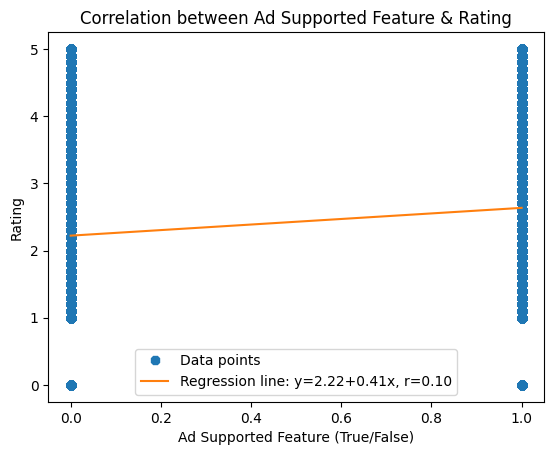

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='8', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Ad Supported Feature (True/False)')
ax.set_ylabel('Rating')
ax.set_title('Correlation between Ad Supported Feature & Rating')
ax.legend(facecolor='white')
plt.show()

In [ ]:
add_supported_and_rating=df[['Ad Supported','Rating']]

#for ad supported True
supported_true=add_supported_and_rating[add_supported_and_rating['Ad Supported']==True]
supported_true=supported_true.groupby(['Rating']).size().reset_index(name='Counts')

supported_true.plot(x ='Rating', y='Counts', kind = 'line')
plt.title('Rating for Ad Supported Apps',fontdict={'size':20,'weight':'bold'})
plt.show()


In [ ]:
#for ad supported False
supported_false=add_supported_and_rating[add_supported_and_rating['Ad Supported']==False]
supported_false=supported_false.groupby(['Rating']).size().reset_index(name='Counts')

supported_false.plot(x ='Rating', y='Counts', kind = 'line')
plt.title('Rating for Ad Not Supported Apps',fontdict={'size':20,'weight':'bold'})
plt.show()


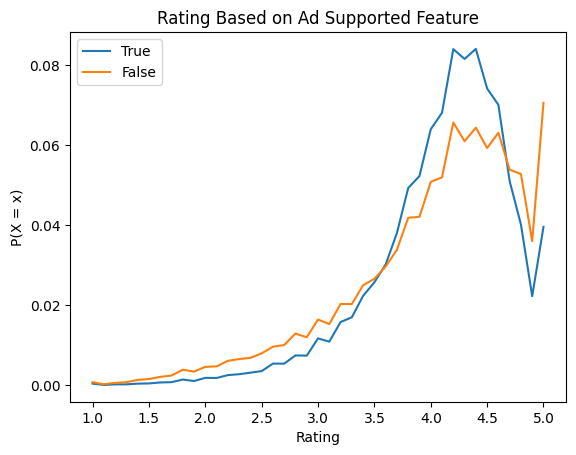

In [ ]:
fig, ax = plt.subplots()
# Extract the unique categories
ad_sup = df['Ad Supported'].unique()
# Filter out 0-star ratings
over_0 = df[df['Rating'] > 0]

for ad in ad_sup:
    pmf_ad_sup = Pmf.from_seq(over_0[over_0['Ad Supported'] == ad]['Rating'])
    ax.plot(pmf_ad_sup, label=ad)

ax.set(title='Rating Based on Ad Supported Feature', xlabel='Rating', ylabel='P(X = x)')

ax.legend()

plt.show();

# Identify the correlation between Ratings and Installs

In [ ]:
x=df['Rating']
y=df['Maximum Installs']

np.corrcoef(x, y)
linregress(x, y)

LinregressResult(slope=220605.42342490764, intercept=-2008.0274560031248, rvalue=0.014902078152097308, pvalue=1.333373869604262e-55, stderr=14043.369507199668)

In [ ]:
slope, intercept, r, p, stderr = linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=-2008.03+220605.42x, r=0.01'

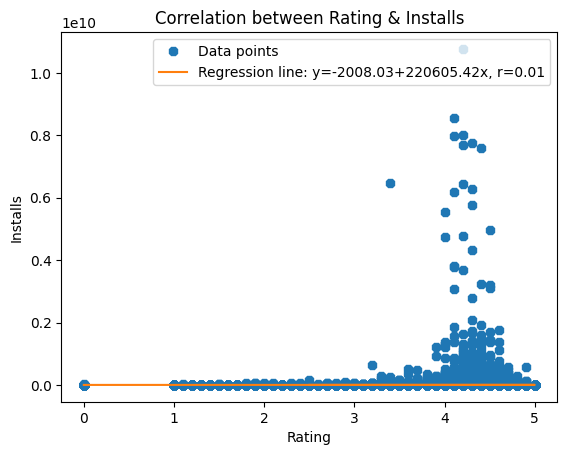

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='8', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Rating')
ax.set_ylabel('Installs')
ax.set_title('Correlation between Rating & Installs')
ax.legend(facecolor='white')
plt.show()

# Identify the correlation between Android App Version and Installation

In [ ]:
x=df['Minimum Android']
y=df['Maximum Installs']

np.corrcoef(x, y)
linregress(x, y)

LinregressResult(slope=124236.74897367325, intercept=28298.121108384978, rvalue=0.0032289583566402318, pvalue=0.0006655223297175243, stderr=36503.58955302727)

In [ ]:
slope, intercept, r, p, stderr = linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=28298.12+124236.75x, r=0.00'

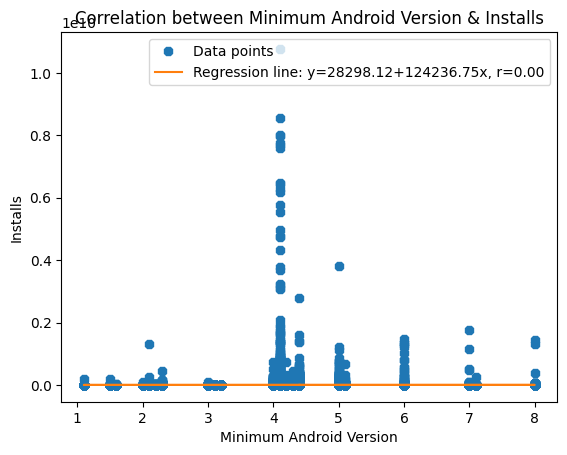

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='8', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Minimum Android Version')
ax.set_ylabel('Installs')
ax.set_title('Correlation between Minimum Android Version & Installs')
ax.legend(facecolor='white')
plt.show()

# Identify whether there is a relationship between Rating Counts and Installations

In [ ]:
x=df['Rating Count']
y=df['Maximum Installs']

np.corrcoef(x, y)
linregress(x, y)

LinregressResult(slope=62.4050905757451, intercept=225308.7376849227, rvalue=0.559159266267439, pvalue=0.0, stderr=0.08778509677740139)

In [ ]:
slope, intercept, r, p, stderr = linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=225308.74+62.41x, r=0.56'

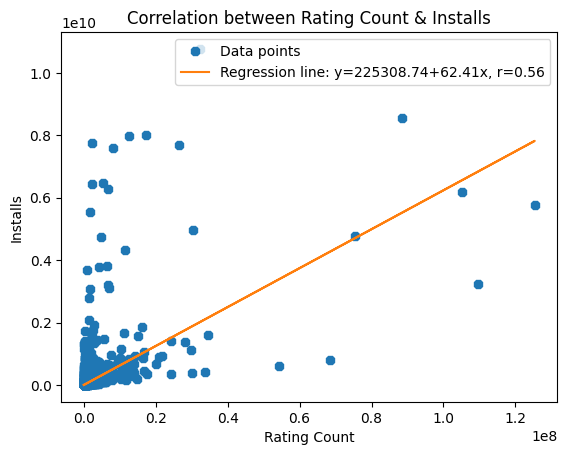

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='8', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Rating Count')
ax.set_ylabel('Installs')
ax.set_title('Correlation between Rating Count & Installs')
ax.legend(facecolor='white')
plt.show()

# Identify whether there is a relationship between App Size and Released Date

In [ ]:
sorted_df=df.sort_values(['Released'], ascending=True)

enc.fit(df['Released'])
df['Released Numerics'] = enc.transform(df['Released'])

x=df['Released Numerics']
y=df['Size']

np.corrcoef(x, y)
linregress(x, y)

LinregressResult(slope=0.0023060539957111474, intercept=11.01802013942211, rvalue=0.0854364029796418, pvalue=0.0, stderr=2.5514429713213946e-05)

In [ ]:
slope, intercept, r, p, stderr = linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=11.02+0.00x, r=0.09'

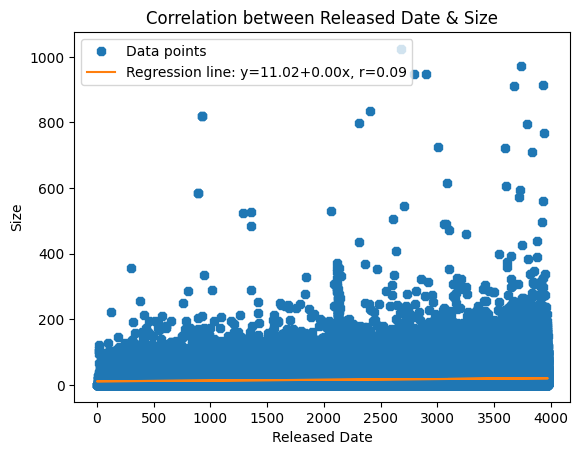

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='8', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Released Date')
ax.set_ylabel('Size')
ax.set_title('Correlation between Released Date & Size')
ax.legend(facecolor='white')
plt.show()

# Identify whether there is a relationship between ratings and period of existence

In [ ]:
df['Days of Existence'] = pd.to_datetime(str(date.today()), format='%Y-%m-%d') - df['Released']

if df['Days of Existence'].dtypes == 'timedelta64[ns]' :
   df['Days of Existence']=(df['Days of Existence'] / np.timedelta64(1, 'D')).astype(int)
else :
   df['Days of Existence']=df['Days of Existence']

df

In [ ]:
x=df['Days of Existence']
y=df['Rating']

np.corrcoef(x, y)
linregress(x, y)

LinregressResult(slope=0.0007645425621716693, intercept=1.623895652914059, rvalue=0.2970456825347269, pvalue=0.0, stderr=2.331684647154388e-06)

In [ ]:
slope, intercept, r, p, stderr = linregress(x, y)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

'Regression line: y=1.62+0.00x, r=0.30'

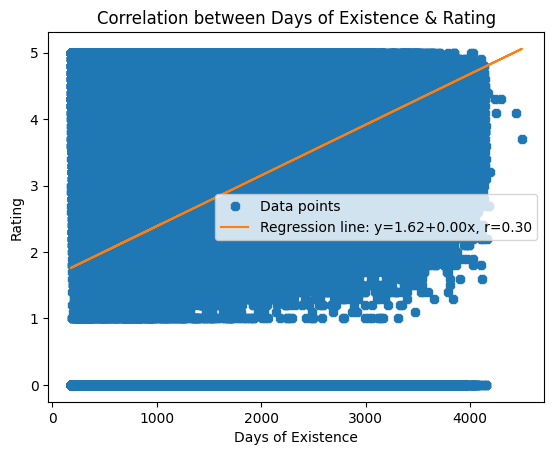

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=0, marker='8', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('Days of Existence')
ax.set_ylabel('Rating')
ax.set_title('Correlation between Days of Existence & Rating')
ax.legend(facecolor='white')
plt.show()

# Installation Prediction

In [ ]:
indexer=StringIndexer(inputCols=["Category","Content Rating"],outputCols=["category_indexed","content_rating_indexed"])
df_installs=indexer.fit(dataset).transform(dataset)
df_installs.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+---------------+--------------------+----------+------------+--------------+------------+----------------+----------------+----------------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free| Size|Minimum Android|        Developer Id|  Released|Last Updated|Content Rating|Ad Supported|In App Purchases|category_indexed|content_rating_indexed|
+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+---------------+--------------------+----------+------------+--------------+------------+----------------+----------------+----------------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True| 29.0|            4.4|   JerLin Production|2019-12-29|  2019-12-30|          Teen|        true|           false|             1.0|            

In [ ]:
featureassembler=VectorAssembler(inputCols=['Rating Count','content_rating_indexed','category_indexed'],outputCol="Independent Features")
output=featureassembler.transform(df_installs)

In [ ]:
finalized_data=output.select("Independent Features","Maximum Installs")
#finalized_data=finalized_data.filter(finalized_data['Maximum Installs'] > 0.0)

In [ ]:
##train test split
train_data,test_data=finalized_data.randomSplit([0.75,0.25])
regressor=LinearRegression(featuresCol='Independent Features', labelCol='Maximum Installs')
regressor=regressor.fit(train_data)

In [ ]:
regressor.coefficients

DenseVector([53.4867, -97288.0237, 2989.7296])

In [ ]:
regressor.intercept

252768.0293277861

In [ ]:
pred_results=regressor.evaluate(test_data)

In [ ]:
prediction_results=pred_results.predictions
prediction_results = prediction_results.orderBy('Maximum Installs', ascending=False)
prediction_results.show()

+--------------------+----------------+--------------------+
|Independent Features|Maximum Installs|          prediction|
+--------------------+----------------+--------------------+
|[3.2425599E7,0.0,...|     10772700105|1.7346070428230176E9|
|[8.8579975E7,1.0,...|      8571451598| 4.738095572367076E9|
|[1626062.0,1.0,29.0]|      5554187901|  8.72149246991246E7|
|[3.0472376E7,0.0,...|      4956331694|1.6301504761837144E9|
|[6324382.0,1.0,21.0]|      3813413261|  3.38488789913628E8|
| [4342585.0,0.0,5.0]|      3788590785|2.3253839709354725E8|
| [1738589.0,1.0,3.0]|      3077276285| 9.315589322936536E7|
|[1417624.0,1.0,16.0]|      2784570767| 7.602739075339484E7|
|[2444387.0,0.0,10.0]|      1749829459|1.3102493788677485E8|
|  [427252.0,0.0,9.0]|      1391532063|2.3131988849241044E7|
| [2896014.0,0.0,9.0]|      1358878122|1.5517800050484103E8|
|  [248357.0,0.0,5.0]|      1314613968|1.3551520995857839E7|
|[1.0461399E7,1.0,...|      1159972740|  5.59707504927335E8|
|[2.9910196E7,0.0,...|  

In [ ]:
pred_results.r2,pred_results.meanAbsoluteError,pred_results.meanSquaredError

(0.37856261745885655, 598292.466645855, 709044827190107.6)

# Rating Prediction





In [ ]:
indexer=StringIndexer(inputCols=["Category","Content Rating"],outputCols=["category_indexed","content_rating_indexed"])
df_ratings=indexer.fit(dataset).transform(dataset)
df_ratings.show()

+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+---------------+--------------------+----------+------------+--------------+------------+----------------+----------------+----------------------+
|            App Name|              App Id|     Category|Rating|Rating Count|Maximum Installs| Free| Size|Minimum Android|        Developer Id|  Released|Last Updated|Content Rating|Ad Supported|In App Purchases|category_indexed|content_rating_indexed|
+--------------------+--------------------+-------------+------+------------+----------------+-----+-----+---------------+--------------------+----------+------------+--------------+------------+----------------+----------------+----------------------+
|     Audiophile Jawa|admobileapps.lang...|Music & Audio|   0.0|           0|              20| True| 29.0|            4.4|   JerLin Production|2019-12-29|  2019-12-30|          Teen|        true|           false|             1.0|            

In [ ]:
featureassembler=VectorAssembler(inputCols=['Size','category_indexed','content_rating_indexed'],outputCol="Independent Features")
output=featureassembler.transform(df_ratings)

In [ ]:
finalized_data=output.select("Independent Features","Rating")

+--------------------+------+
|Independent Features|Rating|
+--------------------+------+
|      [29.0,1.0,1.0]|   0.0|
|     [109.0,6.0,0.0]|   4.6|
|[9.60000038146972...|   4.2|
|      [80.0,1.0,1.0]|   4.5|
|[17.9699993133544...|   4.5|
|[17.9699993133544...|   4.1|
|[17.9699993133544...|   3.3|
|     [17.0,18.0,0.0]|   3.9|
|[17.9699993133544...|   4.2|
|[17.9699993133544...|   4.7|
|     [21.0,13.0,0.0]|   4.6|
|     [16.0,26.0,0.0]|   0.0|
|[17.9699993133544...|   4.1|
|[17.9699993133544...|   2.9|
|[17.9699993133544...|   3.5|
|[17.9699993133544...|   4.6|
|[17.9699993133544...|   4.8|
|     [18.0,24.0,0.0]|   4.0|
|      [48.0,0.0,0.0]|   0.0|
|     [28.0,13.0,0.0]|   3.5|
+--------------------+------+
only showing top 20 rows



In [ ]:
##train test split
train_data,test_data=finalized_data.randomSplit([0.75,0.25])
regressor=LinearRegression(featuresCol='Independent Features', labelCol='Rating')
regressor=regressor.fit(train_data)

In [ ]:
regressor.coefficients

DenseVector([0.0075, 0.0061, 0.1018])

In [ ]:
regressor.intercept

2.2750969913018597

In [ ]:
pred_results=regressor.evaluate(test_data)

In [ ]:
prediction_results=pred_results.predictions
#prediction_results.show()
prediction_results.where((col("Rating") > 3) & (col("Rating") < 5)).show()

+--------------------+------+------------------+
|Independent Features|Rating|        prediction|
+--------------------+------+------------------+
|[0.00999999977648...|   3.8| 2.551161657299278|
|[0.20999999344348...|   4.7|2.4606662012950244|
|[0.30000001192092...|   3.5|2.3386796382955986|
|[0.33000001311302...|   3.8| 2.338904800507608|
|[0.77999997138977...|   3.9| 2.311616720803567|
|[0.81999999284744...|   4.2|2.2873845272859064|
|[0.92000001668930...|   4.9| 2.472128142762662|
|[0.93999999761581...|   3.4| 2.288285176133943|
|       [1.0,5.0,0.0]|   4.0|2.3132679105074203|
|[1.29999995231628...|   4.2| 2.284854019743333|
|[1.29999995231628...|   3.5| 2.315519532180156|
|[1.39999997615814...|   4.3| 2.595957943107484|
|       [1.5,3.0,0.0]|   4.7|2.3047544089170597|
|       [1.5,3.0,0.0]|   4.8|2.3047544089170597|
|       [1.5,5.0,0.0]|   4.7|2.3170206138917893|
|[1.60000002384185...|   4.0|2.3852352821086167|
|[1.70000004768371...|   3.7|2.3675865155023392|
|[1.79999995231628..

In [ ]:
pred_results.r2,pred_results.meanAbsoluteError,pred_results.meanSquaredError

(0.02013690995606754, 1.91736180589414, 4.132791843178976)